this notebook is to tried to make a classification, of the molecules, concenring gas state, mixed, and liquid state. This based on their smile string and the simulation temp.

In [ ]:
import deepchem as dc
import pandas as pd
import numpy as np

In [3]:
# load descriptors
df = pd.read_csv('../csv_files/classification_feats.csv')
descriptors = df["descriptors"].to_list()

In [4]:
print("loading the data...")
loader = dc.data.CSVLoader(["state"], feature_field="smiles", featurizer=dc.feat.RDKitDescriptors(descriptors = descriptors))
Data = loader.create_dataset('../csv_files/RoomTemp_dens_Dataset_WithState.csv')

loading the data...


In [5]:
#some RDKit descriptors return nan, make these 0
X = np.nan_to_num(Data.X, copy=True, nan=0.0, posinf=0)
print("RDKit:",X.shape)

# now load the additional features
df = pd.read_csv('../csv_files/RoomTemp_dens_Dataset_WithState.csv')
Ts = df["temp"].to_numpy()

# combine the RDKit descriptors with the simulation temperature and the boiling temperature
input=np.column_stack((X,Ts))
print("With TS and TB added:",input.shape)

#add data to dataset
Dataset = dc.data.DiskDataset.from_numpy(X=input, y=Data.y, w=Data.w, ids=Data.ids, tasks = ["denstiy"])

RDKit: (668, 20)
With TS and TB added: (668, 21)


In [6]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(Dataset)
print("Data is splitted into: train, valid, test")

Data is splitted into: train, valid, test


In [15]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel

kernel = 1 * RationalQuadratic()
model = dc.models.SklearnModel(GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=1))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")

#predict the test set
predicted_test = model.predict(test_dataset)

fitting model...


c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


model is fitted


c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [16]:
def GetScore(dataset, name_of_set,model):
    #predict the specific dataset
    pred_dataset = model.predict(dataset)

    #get the real values
    y_true = dataset.y.ravel()

    y_pred = []
    for estimations in pred_dataset:
        #this classifier returns a change of which state the molecule will be, so we get the highest one 
        index_maxchance = np.argmax(estimations)
        y_pred.append(index_maxchance)

    #calculate the accuracy:
    from sklearn.metrics import recall_score

    score = recall_score(y_true, y_pred, average='micro')
    print(f"the model predicted the {name_of_set} with an accuracy of {round(score*100,2)}% ")
    return score, y_pred

In [17]:
#evaluate the model
train_score, train_pred = GetScore(train_dataset,"train_dataset",model)
valid_score, valid_pred = GetScore(valid_dataset, "valid_dataset",model)
test_score, test_pred = GetScore(test_dataset, "test_dataset",model)

the model predicted the train_dataset with an accuracy of 96.25% 
the model predicted the valid_dataset with an accuracy of 92.54% 
the model predicted the test_dataset with an accuracy of 94.03% 


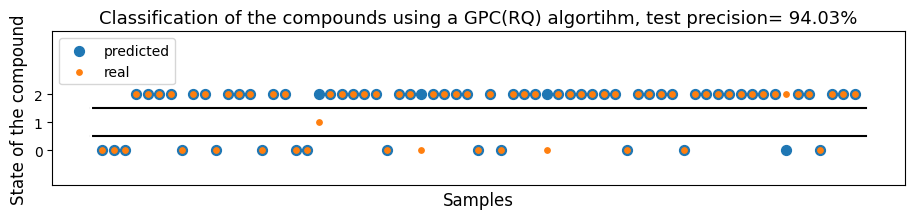

In [18]:
#plot the data
import matplotlib.pyplot as plt

#convert tekst to string, so it can be depicted in matplotlib
text = "Classification of the compounds using a GPC(RQ) algortihm, test precision= "+ str(round(test_score*100,2))  + "%" 

x=[-1,len(test_pred)]
plt.figure(figsize=(11,2))
plt.plot(x, [0.5,0.5],c='black')
plt.plot(x, [1.5,1.5], c='black')
plt.plot((-1,-1),(-1,4),c='white')

plt.scatter(range(len(test_pred)),test_pred, label="predicted",s=50)
plt.scatter(range(len(test_pred)),test_dataset.y, label="real",s=15)
plt.legend(loc="upper left")
plt.yticks([0,1,2])
plt.xticks([])
plt.xlabel("Samples", fontsize=12)
plt.ylabel("State of the compound",fontsize=12)
plt.title(text,fontsize = 13)
plt.show()